## Tema

#### El consumo de alcohol en estudiantes de secundaria

## Título de proyecto

#### Proyecto EDA: Estudio de causas promotoras del consumo de alcohol en estudiantes de secundaria

## Hipótesis

#### El consumo de alcohol en estudiantes de secundaria deriva en mayor medida de pautas educacionales impuestos por los padres como la concesión de tiempo libre en sus hijos o la dedicación en educarlos y no de factores intrínsecos al alumno ni propio del entorno. En este proyecto también se busca confirmar que valores bajos de consumo de alcohol en menores de edad resulta en un mejor rendimiento académico y en una mayor predisposición a encontrar más motivaciones en los estudios.

## Datasets

#### Link de Dataset de partida: http://madm.dfki.de/downloads

#### El dataset que se trabaja en este proyecto contiene 27000 imágenes terrestres y geolocalizables del satélite Sentinel-2, de acceso público y aportadas por el programa Europeo de observación Copernicus.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils.visualization_tb as vi
import utils.mining_data_tb as mn
import utils.folders_tb as fol
import os
import squarify as sq
from sqlalchemy import create_engine
from utils.mysql_tb import MySQL, connect_mysql

import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras




In [3]:
vi.sns_gstyle()

%matplotlib inline

In [4]:
#El dataset con el que se trabaja en este proyecto se encuentra en "data/downloads/sentinel_2". Lo primero que se va a hacer es, desde la ruta del archivo descargado, importar los nombres de las distintas carpetas que clasifican las imágenes descargadas.

ds_dir = ".." + os.sep + "data" + os.sep + "downloads" + os.sep + "sentinel_2"

download_folders = os.listdir(ds_dir)
download_folders

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [5]:
#Para evitar errores durante el procesado, se filtran las imágenes que puedan estar corruptas.

def delete_corrupted_images(folders, folders_dir):
    """Esta función borra imágenes corruptas dentro de un dataset compuesta por subsets              correspondientes a carpetas que contienen agrupaciones de imágenes"""
    num_skipped = 0
    for folder_name in folders:
        folder_path = os.path.join(folders_dir, folder_name)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                fobj = open(fpath, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                os.remove(fpath)

    print(f"Borradas {num_skipped} imágenes")

delete_corrupted_images(folders=download_folders, folders_dir=ds_dir)

Borradas 0 imágenes


In [ ]:
#El dataset no contiene imágenes corruptas.

In [6]:
#Con las imágenes ya organizadas, se genera un conjunto de entrenamiento y un conjunto de validación.

print("Conjunto de entrenamiento:")

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  ds_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(64, 64),
  batch_size=32,
  labels="inferred",
  label_mode="categorical",
  color_mode="rgb"
  )

print("\nConjunto de validación:")

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  ds_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(64, 64),
  batch_size=32,
  labels="inferred",
  label_mode="categorical",
  color_mode="rgb",
  )


Conjunto de entrenamiento:
Found 27000 files belonging to 10 classes.
Using 21600 files for training.

Conjunto de validación:
Found 27000 files belonging to 10 classes.
Using 5400 files for validation.


In [15]:
y = np.concatenate([y for x, y in train_ds], axis=0)

In [17]:
y.shape

(21600, 10)

In [12]:
train_ds

<BatchDataset shapes: ((None, 64, 64, 3), (None, 10)), types: (tf.float32, tf.float32)>

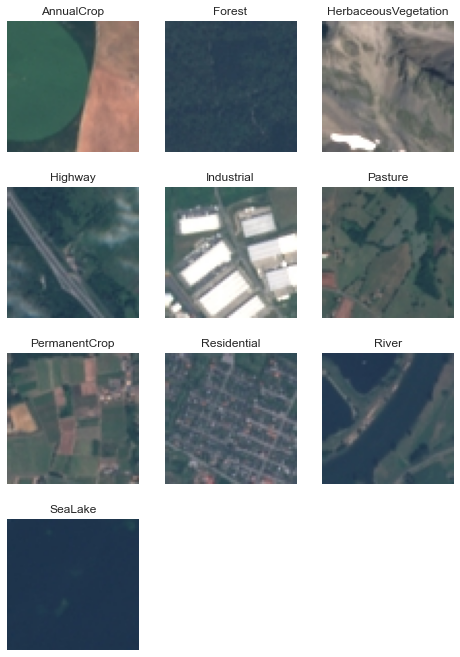

In [102]:
#Se visualiza la data con la librería matplotlib.pyplot. En este caso, como tardaría mucho en reproducir todos los valores y sus clases, se coge 1 valor de cada clase para poder identificar como se trabajan las imágenes con sus respectivas clases.

image_indexes = [1]
selected_image_file_paths = dict()

for classification in download_folders:
    image_directory = os.path.join(ds_dir, classification)
    image_file_names = os.listdir(image_directory)
    selected_image_file_paths[classification] = [join(image_directory, image_file_names[i]) for i in image_indexes]
plt.figure(figsize=(8,30))
    
for i,classification in enumerate(download_folders):
    for j,image in enumerate(selected_image_file_paths[classification]):
        image_number = (i * len(image_indexes)) + j + 1
        ax = plt.subplot(10,3,image_number)
        plt.title(classification)
        plt.axis("off")
        plt.imshow(mpimg.imread(image))

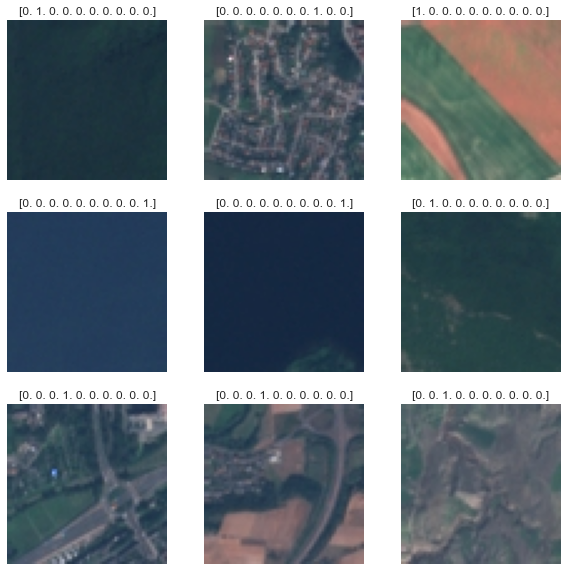

In [87]:
#Con tensorflow, se guardan dichas clases como labels en arrays de 10 de longitud, correspondiendo a las 10 clases que habían originalmente. En este paso, se muestra como cada imágen se corresponde con un label (target) particular.

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        for t, classification in enumerate(download_folders):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(str(labels.numpy()[i]))
            plt.axis("off")

In [30]:
model = keras.Sequential([
    keras.layers.experimental.preprocessing.Rescaling(1.0 / 255),
    keras.layers.Conv2D(64, (3, 3), padding="same", input_shape=(64, 64, 1),activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    #keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation="softmax")
])

In [34]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
model.fit(train_ds, epochs=10)

Epoch 1/10
675/675 [==============================] - 51s 74ms/step - loss: 1.2797 - accuracy: 0.5352
Epoch 2/10
675/675 [==============================] - 51s 75ms/step - loss: 0.8498 - accuracy: 0.6938
Epoch 3/10
675/675 [==============================] - 50s 74ms/step - loss: 0.6895 - accuracy: 0.7550
Epoch 4/10
675/675 [==============================] - 50s 75ms/step - loss: 0.5954 - accuracy: 0.7896
Epoch 5/10
675/675 [==============================] - 50s 74ms/step - loss: 0.5183 - accuracy: 0.8162
Epoch 6/10
675/675 [==============================] - 50s 74ms/step - loss: 0.4326 - accuracy: 0.8489
Epoch 7/10
675/675 [==============================] - 53s 79ms/step - loss: 0.3853 - accuracy: 0.8673
Epoch 8/10
675/675 [==============================] - 52s 78ms/step - loss: 0.3377 - accuracy: 0.8819
Epoch 9/10
675/675 [==============================] - 50s 74ms/step - loss: 0.3005 - accuracy: 0.8963
Epoch 10/10
675/675 [==============================] - 52s 77ms/step - loss: 0.260

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               8388736   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 8,391,818
Trainable params: 8,391,818
Non-trainable params: 0
______________________________________________

In [12]:
#Se buscan NaN values en el dataframe.
mn.null_in_dataframe(data)


El dataframe no contiene valores nulos.


In [13]:
#Se observa que muchas de las columnas tienen tipologia objeto para sus valores. Se analizan los valores de cada columna.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1044 entries, 0 to 648
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sex         1044 non-null   object
 1   age         1044 non-null   int64 
 2   address     1044 non-null   object
 3   famsize     1044 non-null   object
 4   Pstatus     1044 non-null   object
 5   Medu        1044 non-null   int64 
 6   Fedu        1044 non-null   int64 
 7   reason      1044 non-null   object
 8   guardian    1044 non-null   object
 9   traveltime  1044 non-null   int64 
 10  studytime   1044 non-null   int64 
 11  failures    1044 non-null   int64 
 12  schoolsup   1044 non-null   object
 13  famsup      1044 non-null   object
 14  paid        1044 non-null   object
 15  activities  1044 non-null   object
 16  nursery     1044 non-null   object
 17  higher      1044 non-null   object
 18  internet    1044 non-null   object
 19  romantic    1044 non-null   object
 20  famrel   

In [14]:
#Se buscan valores de tipo objeto que se pueden pasar a numéricos binarios.
mn.check_columns_unique(data)

La columna sex tiene estos valores únicos: ['F' 'M']
La columna age tiene estos valores únicos: [18 17 15 16 19 22 20 21]
La columna address tiene estos valores únicos: ['U' 'R']
La columna famsize tiene estos valores únicos: ['GT3' 'LE3']
La columna Pstatus tiene estos valores únicos: ['A' 'T']
La columna Medu tiene estos valores únicos: [4 1 3 2 0]
La columna Fedu tiene estos valores únicos: [4 1 2 3 0]
La columna reason tiene estos valores únicos: ['course' 'other' 'home' 'reputation']
La columna guardian tiene estos valores únicos: ['mother' 'father' 'other']
La columna traveltime tiene estos valores únicos: [2 1 3 4]
La columna studytime tiene estos valores únicos: [2 3 1 4]
La columna failures tiene estos valores únicos: [0 3 2 1]
La columna schoolsup tiene estos valores únicos: ['yes' 'no']
La columna famsup tiene estos valores únicos: ['no' 'yes']
La columna paid tiene estos valores únicos: ['no' 'yes']
La columna activities tiene estos valores únicos: ['no' 'yes']
La columna n

In [15]:
#Se buscan valores anómalos y outliers. Llama la atención los valores máximos de ausencias, fallos y edad. Los demás son asumibles y necesarios para la comprensión del caso a estudiar ya que, no es un parámetro que tenga que estudiarse únicamente con estudiantes promedio.
data.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,absences,alcohol,grade
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,16.726054,2.603448,2.387931,1.522989,1.970307,0.264368,3.935824,3.201149,3.156130,4.434866,3.778736,33.801724
std,1.239975,1.124907,1.099938,0.731727,0.834353,0.656142,0.933401,1.031507,1.152575,6.210017,1.988434,9.656416
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,2.000000,4.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,0.000000,2.000000,28.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,2.000000,3.000000,34.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,6.000000,5.000000,40.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,75.000000,10.000000,58.000000


In [16]:
#Se analizan las columnas de ausencias, fallos y edad, para sus valores máximos ya que se alejan mucho de la desviación estándar y pueden ser considerado como anómalos si se encuentran aislados.

mn.max_values(30, data, ["absences", "failures", "age"])

#Se puede ver, que en la columna ausencias, los valores se normalizan a partir de valor = 22, los sujetos que superan ese valor se alejan demasiado de la desviación estandar y pueden ser considerados como anómalos ya que son pocos pero pueden alterar en gran medida el resultado que se obtiene después de aplicar las comprobaciones. Asimismo, se decide estudiar del Dataframe aquellos casos en que la edad supera los 19 años, ya que son unos pocos casos aislados que pueden tener gran impacto en los resultados gráficos. En la columna de suspensos, el valor = 3 es un valor normalizado que,por estar en una columna de 4 valores únicos, queda marcado como outlier, pero nos interesa mantenerlo en nuestro estudio, ya que no supone un valor anómalo que quede fuera de la comprensión para el caso a estudiar. 

Primeros 30 valores de la columna absences
276    75
183    56
74     54
315    40
307    38
197    32
212    30
280    30
205    28
256    26
103    26
40     25
198    24
150    24
320    23
325    22
277    22
313    22
216    22
155    22
413    21
260    21
217    21
304    20
311    20
118    20
237    20
281    19
309    18
89     18
Name: absences, dtype: int64
Primeros 30 valores de la columna failures
150    3
18     3
127    3
237    3
543    3
350    3
478    3
78     3
557    3
279    3
247    3
568    3
571    3
18     3
392    3
610    3
78     3
173    3
206    3
131    3
2      3
157    3
149    3
146    3
170    3
169    3
144    3
179    3
164    3
153    3
Name: failures, dtype: int64
Primeros 30 valores de la columna age
279    22
247    22
392    21
407    21
413    21
506    20
414    20
390    20
376    20
351    20
299    20
574    20
421    20
306    20
415    19
350    19
504    19
311    19
322    19
127    19
491    19
488    19
341    19
480    19
419    1

In [17]:
#Se aplica una función que compara los valores de las medias de la tabla modificada con un mask que compara con valores mayores a una columna, con el DataFrame matriz.

mn.comp_data(data=data, column = "age", mask_value = 19)

#Como se puede comprobar a continuación, las medias de ingesta de alcohol y ausencias quedan totalmente apartadas de los resultados que se proporcionan con el dataset entero. Asimismo, las medias de los demás parámetros de estudio se distribuyen ligeramente hacia tendencias más ociosas,favoreciendo costumbres no relacionadas con los estudios. Por la desviación que ofrecen estos casos, los omitiremos y no entrarán en el proyecto de estudio.

,Total,age > 19
age,16.726054,20.500000
Medu,2.603448,2.285714
Fedu,2.387931,1.571429
traveltime,1.522989,1.500000
studytime,1.970307,1.714286
failures,0.264368,1.571429
famrel,3.935824,4.214286
freetime,3.201149,3.714286
goout,3.156130,3.142857
absences,4.434866,7.714286


In [18]:
#Para corroborar que las desviaciones que esas edades provocaban no son regulares en el dataset, se estudian las medias de los años anteriores para estudiar la correlación de desviación con edad.

mn.comp_multiple_data(data=data, column = "age", mask_list = [15,16,17,18,19])

#Como se puede observar, para la mayoría de sujetos (filas) se establece una tendencia a medida que evoluciona la edad, pero no es tan considerable como con los casos que se pretenden omitir.

,Total,age = 15,age = 16,age = 17,age = 18,age = 19
age,16.726054,15.000000,16.000000,17.000000,18.000000,19.000000
Medu,2.603448,2.871134,2.629893,2.534296,2.572072,2.089286
Fedu,2.387931,2.608247,2.444840,2.321300,2.373874,1.928571
traveltime,1.522989,1.453608,1.508897,1.519856,1.603604,1.535714
studytime,1.970307,2.072165,1.871886,1.942238,2.063063,1.946429
failures,0.264368,0.134021,0.160142,0.227437,0.288288,1.000000
famrel,3.935824,4.000000,3.839858,3.981949,3.963964,3.785714
freetime,3.201149,3.268041,3.170819,3.212996,3.090090,3.375000
goout,3.156130,2.804124,3.174377,3.241877,3.333333,3.160714
absences,4.434866,3.097938,3.882562,4.924188,4.869369,6.875000


In [19]:
#Se dejan los outliers deseados fuera.
data = mn.outlier_clean(data=data, kind="custom", dict_cols_max= {"absences": 22, "age": 19})
data

La forma de la data resultante es: (1015, 26)


,sex,age,address,famsize,Pstatus,Medu,Fedu,reason,guardian,traveltime,...,nursery,higher,internet,romantic,famrel,freetime,goout,absences,alcohol,grade
0,F,18,U,GT3,A,4,4,course,mother,2,...,yes,yes,no,no,4,3,4,6,2,17
1,F,17,U,GT3,T,1,1,course,father,1,...,no,yes,yes,no,5,3,3,4,2,16
2,F,15,U,LE3,T,1,1,other,mother,1,...,yes,yes,yes,no,4,3,2,10,5,25
3,F,15,U,GT3,T,4,2,home,mother,1,...,yes,yes,yes,yes,3,2,2,2,2,44
4,F,16,U,GT3,T,3,3,home,father,1,...,yes,yes,no,no,4,3,2,4,3,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,F,19,R,GT3,T,2,3,course,mother,1,...,no,yes,yes,no,5,4,2,4,3,31
645,F,18,U,LE3,T,3,1,course,mother,1,...,yes,yes,yes,no,4,3,4,4,2,46
646,F,18,U,GT3,T,1,1,course,mother,2,...,yes,yes,no,no,1,1,1,6,2,32
647,M,17,U,LE3,T,3,1,course,mother,2,...,no,yes,yes,no,2,4,5,6,7,30


In [20]:
#Ahora que están limpios los datos, se reinicia el índice.
data = data.reset_index(drop=True)

In [21]:
#Se guarda una copia en data como dataset limpio .json que se va a utilizar para los distintos pasos del proyecto.
fol.create_json(".." + os.sep + "data" + os.sep + "cleaned_data.json", data)


In [22]:
#Se guarda otra copia en formato .csv en la misma altura.
data.to_csv(".." + os.sep + "reports" + os.sep + "from_main" + os.sep + "cleaned_data.csv")

In [23]:
#Se guarda una segunda copia .json en otra ruta para trabajar en el notebook.
fol.create_json(".." + os.sep + "reports" + os.sep + "from_main" + os.sep + "cleaned_data.json", data)

In [24]:
#Se sube una copia del dataframe al servidor de MySQL propuesto para el proyecto. Primero, se establece la conexión con el servidor, que vendrá apoyada con la funcionalidad del módulo mysql_tb en la que se encuentra la clase MYSQL.
db_connection = connect_mysql(IP_DNS="54.87.229.244", USER="21755015m", PASSWORD="adriagallardo96", BD_NAME="21755015m_ds_april_2021_db", PORT=25001)

Connected to MySQL server [21755015m_ds_april_2021_db]


In [25]:
#Por consiguiente, se sube el DataFrame al servidor.
data.to_sql(name="21755015m_ds_april_2021_db_tb", con=db_connection, if_exists="replace", index=False)

In [26]:
#Finalmente, se comprueba que se haya subido correctamente con una lectura del DataFrame

pd.read_sql_table("21755015m_ds_april_2021_db_tb", db_connection)

,sex,age,address,famsize,Pstatus,Medu,Fedu,reason,guardian,traveltime,...,nursery,higher,internet,romantic,famrel,freetime,goout,absences,alcohol,grade
0,F,18,U,GT3,A,4,4,course,mother,2,...,yes,yes,no,no,4,3,4,6,2,17
1,F,17,U,GT3,T,1,1,course,father,1,...,no,yes,yes,no,5,3,3,4,2,16
2,F,15,U,LE3,T,1,1,other,mother,1,...,yes,yes,yes,no,4,3,2,10,5,25
3,F,15,U,GT3,T,4,2,home,mother,1,...,yes,yes,yes,yes,3,2,2,2,2,44
4,F,16,U,GT3,T,3,3,home,father,1,...,yes,yes,no,no,4,3,2,4,3,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,F,19,R,GT3,T,2,3,course,mother,1,...,no,yes,yes,no,5,4,2,4,3,31
1011,F,18,U,LE3,T,3,1,course,mother,1,...,yes,yes,yes,no,4,3,4,4,2,46
1012,F,18,U,GT3,T,1,1,course,mother,2,...,yes,yes,no,no,1,1,1,6,2,32
1013,M,17,U,LE3,T,3,1,course,mother,2,...,no,yes,yes,no,2,4,5,6,7,30


In [27]:
#Se crea una tabla para trabajar con valores binarios como "integers", la paso a llamar data_b y queda guardada como variable.
data_binary = data.copy()
mn.bin_obj_to_int(data=data_binary)
data_binary

,sex,age,address,famsize,Pstatus,Medu,Fedu,reason,guardian,traveltime,...,nursery,higher,internet,romantic,famrel,freetime,goout,absences,alcohol,grade
0,1,18,1,1,1,4,4,course,mother,2,...,1,1,1,1,4,3,4,6,2,17
1,1,17,1,1,0,1,1,course,father,1,...,0,1,0,1,5,3,3,4,2,16
2,1,15,1,0,0,1,1,other,mother,1,...,1,1,0,1,4,3,2,10,5,25
3,1,15,1,1,0,4,2,home,mother,1,...,1,1,0,0,3,2,2,2,2,44
4,1,16,1,1,0,3,3,home,father,1,...,1,1,1,1,4,3,2,4,3,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,1,19,0,1,0,2,3,course,mother,1,...,0,1,0,1,5,4,2,4,3,31
1011,1,18,1,0,0,3,1,course,mother,1,...,1,1,0,1,4,3,4,4,2,46
1012,1,18,1,1,0,1,1,course,mother,2,...,1,1,1,1,1,1,1,6,2,32
1013,0,17,1,0,0,3,1,course,mother,2,...,0,1,0,1,2,4,5,6,7,30


In [28]:
#Se guarda una copia en el notebook de esta también.
fol.create_json(".." + os.sep + "reports" + os.sep + "from_main" + os.sep + "cleaned_data_binary.json", data_binary)

In [29]:
#Se analizan las correlaciones entre la ingesta de alcohol y las demás. Se utiliza data_b para trabajar también con los valores binarios.
correlation_alc = data_binary.corr()['alcohol'].sort_values()
correlation_alc 

sex          -0.321911
studytime    -0.219561
grade        -0.143870
famrel       -0.114214
famsize      -0.092260
higher       -0.090033
nursery      -0.086772
schoolsup    -0.068657
address      -0.062746
paid         -0.049791
internet     -0.048251
Pstatus      -0.039846
Medu         -0.016069
activities   -0.005149
romantic      0.000251
Fedu          0.021071
famsup        0.059155
failures      0.093758
age           0.102903
traveltime    0.114741
freetime      0.142430
absences      0.170879
goout         0.371193
alcohol       1.000000
Name: alcohol, dtype: float64

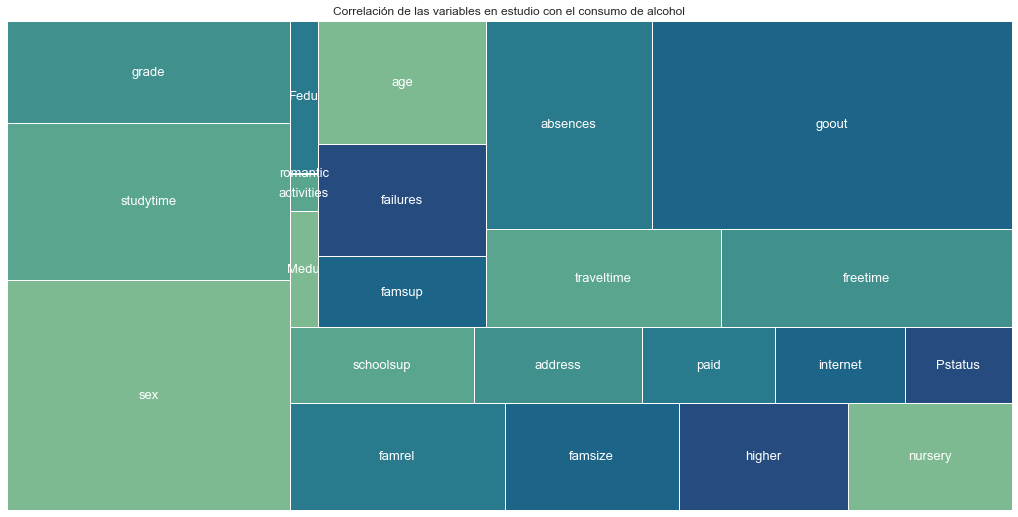

In [30]:
#Con este estudio de correlaciones, se puede observar que "goout", "sex" , "studytime" y "absences", son las columnas más correlacionadas con "alcohol". Seguido de grade y freetime.

vi.corr_onevalue_graphic_abs(data=correlation_alc, variable = "el consumo de alcohol")
plt.savefig(".." + os.sep + "reports" + os.sep + "from_main" + os.sep + "images" + os.sep + "correlation_alcohol_abs.jpg")

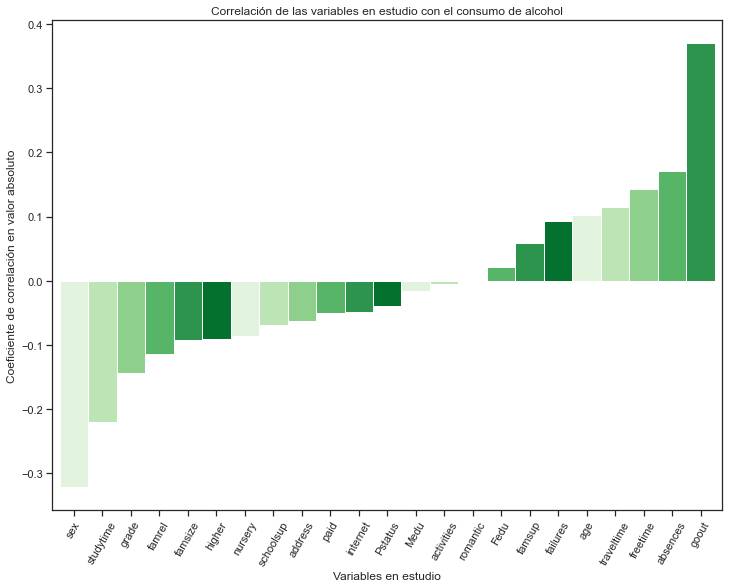

In [31]:
#A continuación se muestran también las correlaciones negativas para asegurar que no se tratan los parámetros al contrario de como se debería.

vi.corr_onevalue_graphic_n(data=correlation_alc, variable = "el consumo de alcohol")
plt.savefig(".." + os.sep + "reports" + os.sep + "from_main" + os.sep + "images" + os.sep + "correlation_alcohol.jpg")


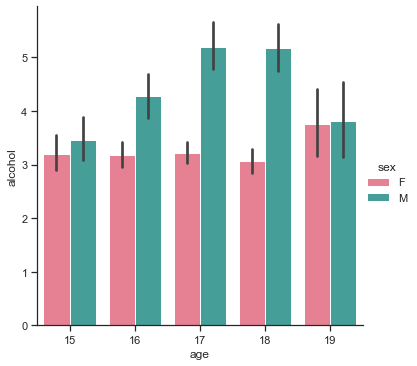

In [32]:
#En la hipotesis, se plantea que los factores determinados parentalmente, son los que más afectación tienen sobre el alumno a la hora de consumir alcohol. Sin embargo, se muestra una excepción, el sexo. Debido a esto, se genera la siguiente cuestión ¿Por que el sexo diferencia tanto a los alumnos con la ingesta de alcohol?
sns.catplot(data=data, x="age", y="alcohol", kind="bar", hue="sex", palette="husl")
plt.savefig(".." + os.sep + "reports" + os.sep + "from_main" + os.sep + "images" + os.sep + "alcohol_age.jpg")


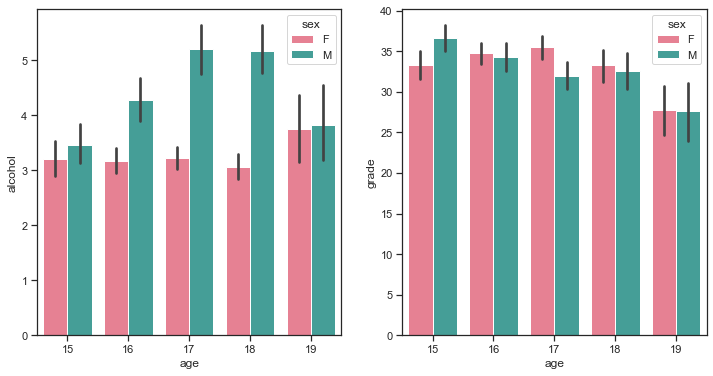

In [33]:
#Como se puede observar, el sexo no influye considerablemente sobre la nota, pero sí sobre la tendencia que dirige el consumo de alcohol con la edad. Y se puede ver simultaneamente, con el sexo masculino, para las edades determinadas, que cuando incrementan considerablemente los valores de consumo de alcohol, disminuye la nota de los sujetos del sexo masculino en contraposición a los sujetos femeninos. Por este motivo, como el sexo presenta valores tan dispares a la hora de estudiar las correlaciones con el alcohol, se realizará un estudio para ambos casos de sexo, para determinar si la correlación de sexo se aplica como factor biológico, o hay factores sociológicos que diferencian ambos sexos.

vi.doble_barplot(x="age", y1="alcohol", y2="grade", hue="sex", figsize=(12,6), data=data )
plt.savefig(".." + os.sep + "reports" + os.sep + "from_main" + os.sep + "images" + os.sep + "alcohol_grade_age.jpg")

#En el camino que se sigue, se pueden obtener 2 conclusiones: que el sexo sea un factor biológico determinante en el consumo de alcohol porque los sujetos masulinos o femeninos tienen más "apetito" por él, o que el sexo determine patrones sociológicos que resulten en generar una mayor correlación sobre la ingesta de acohol, en cuyo caso, podríamos determinar que también son medidas sistemáticas educacionales que desembocan en este resultado de dispariedad.


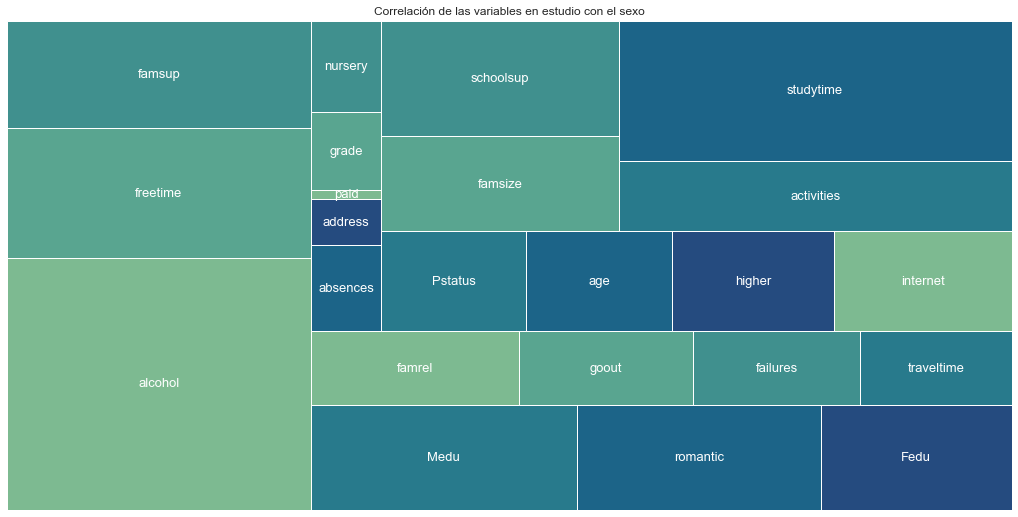

In [34]:
#Para verificar lo anteriormente dicho, como muestra la gráfica a continuación, el sexo y las notas no tienen apenas correlación.
vi.corr_onevalue_graphic_abs(data=data_binary.corr().sex.sort_values(), variable = "el sexo")
plt.savefig(".." + os.sep + "reports" + os.sep + "from_main" + os.sep + "images" + os.sep + "correlation_sex_abs.jpg")

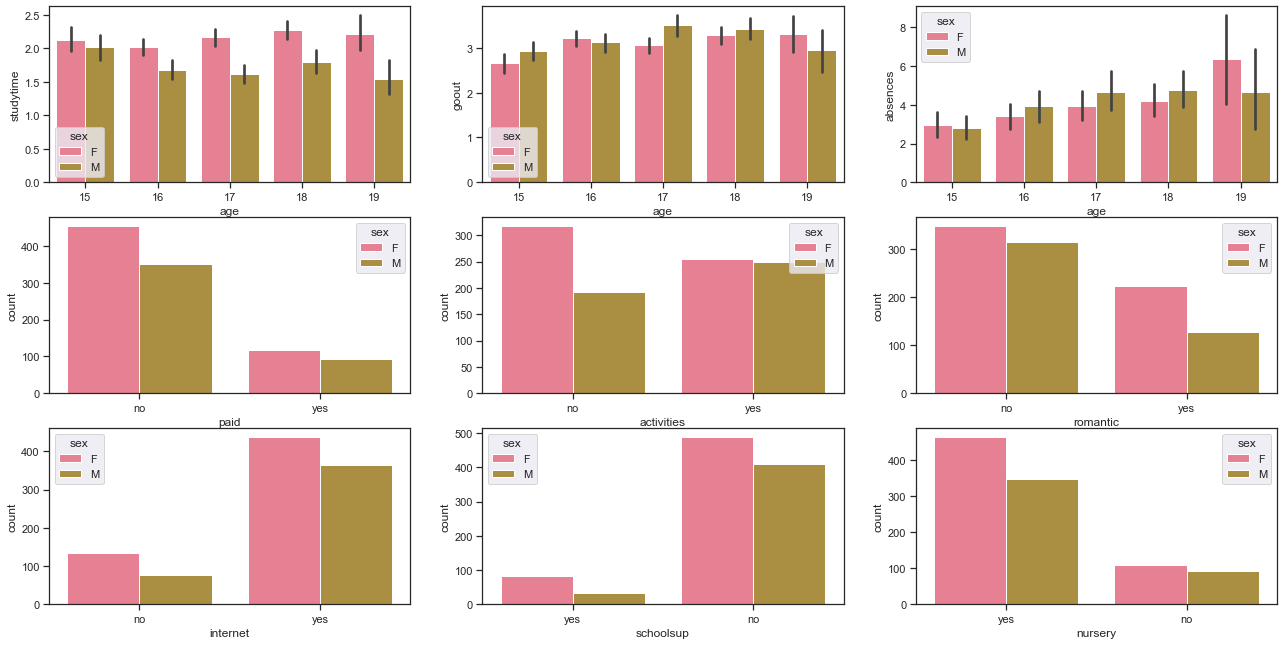

In [35]:
#A continuación, se utilizan gráficos referenciados a columnas del Dataframe para determinar si el sexo dictamina diferencias en las costumbres cuotidianas de los alumnos.

vi.multi_subplot(data=data)
plt.savefig(".." + os.sep + "reports" + os.sep + "from_main" + os.sep + "images" + os.sep + "sex_subplots.jpg")
#De base, a los 15 años en las gráficas studytime y absences, se puede ver que los sujetos femeninos tienen valores mínimamente por encima de los valores que presentan los sujetos masculinos. No obstante, con el paso de la edad, se observa como, significativamente, los sujetos masculinos dedican menos tiempo al estudio y más a salir y a no participar a clase. Es decir, los sujetos femeninos se mantienen más estables en el paso de edad mientras que los masculinos rompen con una tendencia que coincide con la que presentaba el consumo de alcohol. 

#Para justificar que el sexo es no es un factor únicamente biológico, sino que también social, se estudian las otras 6 tablas. En proporción, "paid"(clases privadas), "nursery"(asistencia a guardería) y "internet"(acceso a internet desde casa) son ligeramente similares. Sin embargo, también se encuentran diferencias en las otras: los sujetos femeninos participan a muchas menos actividades extraescolares("activities"), tienen pareja con más asiduidad ("romantic") y tienen muchos más casos de soporte educacional en la escuela ("schoolsup"), dato que lleva a pensar que no es solo una cuestión biológica la que dicta la dirección que marca la ingesta de alcohol, sino que el apoyo académico puede verse superior en los sujetos femeninos.

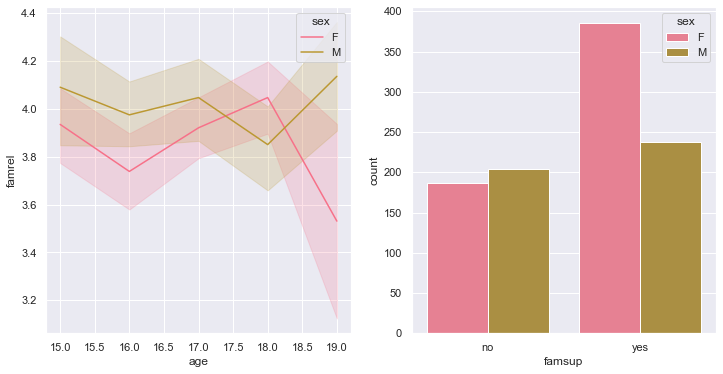

In [36]:
#Para confirmar lo último supuesto, trabajaremos con dos tablas más, que definen la situación de los alumnos, dividos por sexo y edad, con sus familiares. Como se puede analizar,no hay patrones de cambio en la relación de los alumnos con sus familiares ("famrel"), ni valores de diferencia significativos. Sin embargo, a pesar de tener relaciones similares, los sujetos femeninos tienen mucho más soporte educacional en sus padres que los sujetos masculinos, lo que lleva a pensar, que en realidad, el sexo no es una propiedad intrínseca que provoca que los sujetos beban más o no, sino que socialmente ya se aplican métodos distintos, o hay visiones distintas sobre el individuo por su sexo que implica diferencias educacionales en su experiencia vitalicia.

vi.line_count(data=data, x1="age", x2="famsup", y="famrel", hue="sex", figsize=(12,6))
plt.savefig(".." + os.sep + "reports" + os.sep + "from_main" + os.sep + "images" + os.sep + "fam_subplots.jpg")

In [37]:
#En resumen, la primera parte de la hipotesis se confirma, existen motivos significativos en las pautas educativas de los tutores para definir la tasa de consumo de alcohol del sujeto. Mayormente, por definición de los tiempos de estudio y tiempo libre y la varianza de soporte educacional según el sexo. En contraposición, se encuentra poca correlación con el tipo de población (urbana o rural), la edad del alumno, su situación sentimental, la situación de la relación familiar o la educación de los padres, por ejemplo. Para estos últimos casos, no se puede definir que haya pautas educativas clasificadas, pero si que las hay al permitir que los alumnos gocen de largos tiempos de libertad y no tengan la obligatoriedad o necesidad de llevar a cabo largos tiempos de estudio o solicitar ayuda académica. 

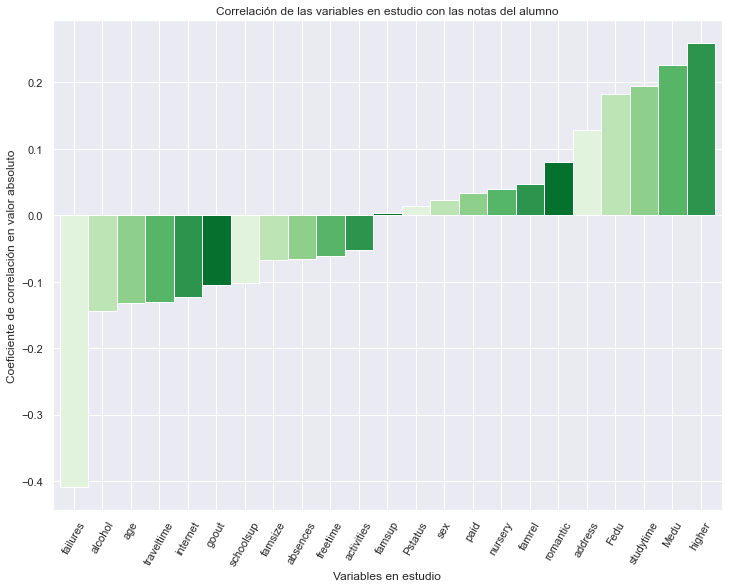

In [38]:
#La segunda parte de la hipotesis busca analizar la correlación entre el alcohol, las notas del grado, y, como punto final, las motivaciones que el alumno presenta para seguir formandose. En este caso se utiliza una tabla con correlaciones positivas y negativas.

#Como se ha especificado anteriormente, la correlación entre el alcohol y las notas no es muy significativa (-0.14), por lo que sí, existe una pequeña correlación y se puede justificar que si el alumno aumenta su ingesta de alcohol, hay riesgo de obtener peores notas, pero no tanta como para afirmar que los alumnos que beben obtienen peores notas. No obstante, "higher", el parámetro que estudia la motivación de los alumnos para seguir estudiando al finalizar, indica que a medida que aumenta las notas de los alumnos en el dataset, también lo hacen sus motivaciones académicas. Por lo que, se confirma también la segunda parte de la hipótesis.

vi.corr_onevalue_graphic_n(data=data_binary.corr()['grade'].sort_values(), variable = "las notas del alumno")
plt.savefig(".." + os.sep + "reports" + os.sep + "from_main" + os.sep + "images" + os.sep + "correlation_grades.jpg")